SCIP status:presolving:
 optimal

Optimal solution:
  Gas    : p_Gas =  60.00 MW (cap 60.0, cost 20.0 €/MWh)
  Coal   : p_Coal =  40.00 MW (cap 40.0, cost 40.0 €/MWh)
  Peaker : p_Peaker =  20.00 MW (cap 100.0, cost 120.0 €/MWh)

Total cost: 5200.00 €
(round 1, fast)       1 del vars, 0 del conss, 0 add conss, 1 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       1 del vars, 0 del conss, 0 add conss, 1 chg bounds, 1 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
presolving (3 rounds: 3 fast, 1 medium, 1 exhaustive):
 3 deleted vars, 1 deleted constraints, 0 added constraints, 1 tightened bounds, 0 added holes, 1 changed sides, 0 changed coefficients
 0 implications, 0 cliques
transformed 1/1 original solutions to the transformed problem space
Presolving Time: 0.00

SCIP Status        : problem is solved [optimal solution found]
Solving Time (sec) : 0.00
Solving Nodes      : 0
Primal Bound       : +5.20000000000000e+03 (1 solutions)
Dual Bo

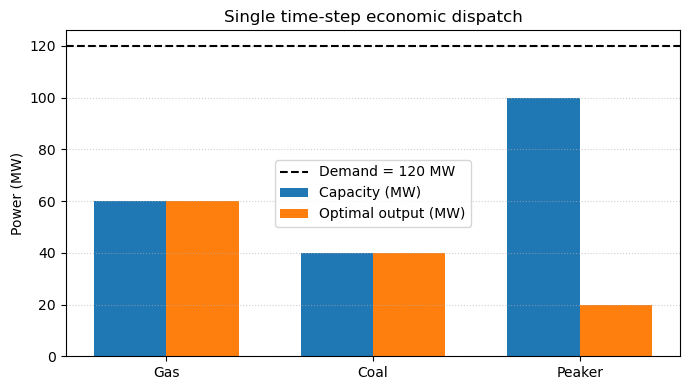

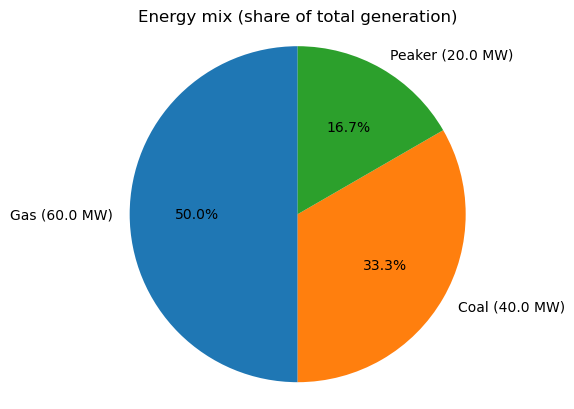

In [3]:
from pyscipopt import Model, quicksum
import matplotlib.pyplot as plt

# ============================================================
# Data
# ============================================================

techs = ["Gas", "Coal", "Peaker"]

cost = {
    "Gas": 20.0,
    "Coal": 40.0,
    "Peaker": 120.0,
}

pmax = {
    "Gas": 60.0,
    "Coal": 40.0,
    "Peaker": 100.0,
}

D = 120.0  # demand (MW)

# ============================================================
# Build model
# ============================================================

m = Model("single_step_economic_dispatch")

p = {i: m.addVar(lb=0.0, ub=pmax[i], name=f"p_{i}") for i in techs}

m.setObjective(quicksum(cost[i] * p[i] for i in techs), sense="minimize")

m.addCons(quicksum(p[i] for i in techs) == D, name="demand_balance")

# ============================================================
# Solve
# ============================================================

m.optimize()
status = m.getStatus()
print("SCIP status:", status)
if status not in ["optimal", "bestsollimit", "timelimit"]:
    raise RuntimeError("No solution available to visualize.")

sol = m.getBestSol()
obj_val = m.getObjVal()
p_sol = {i: sol[p[i]] for i in techs}

print("\nOptimal solution:")
for i in techs:
    print(f"  {i:6s} : p_{i} = {p_sol[i]:6.2f} MW (cap {pmax[i]:.1f}, cost {cost[i]:.1f} €/MWh)")
print(f"\nTotal cost: {obj_val:.2f} €")

# ============================================================
# Visualization 1: capacity vs optimal output
# ============================================================

indices = range(len(techs))
bar_width = 0.35

plt.figure(figsize=(7, 4))

plt.bar(indices,
        [pmax[i] for i in techs],
        width=bar_width,
        label="Capacity (MW)")

plt.bar([i + bar_width for i in indices],
        [p_sol[i] for i in techs],
        width=bar_width,
        label="Optimal output (MW)")

plt.axhline(D, linestyle="--", color="k", label=f"Demand = {D:.0f} MW")

plt.xticks([i + bar_width / 2 for i in indices], techs)
plt.ylabel("Power (MW)")
plt.title("Single time-step economic dispatch")
plt.legend()
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()

# ============================================================
# Visualization 2: energy mix (share of each technology)
# ============================================================

plt.figure()

values = [p_sol[i] for i in techs]
labels = [f"{i} ({p_sol[i]:.1f} MW)" for i in techs]

plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Energy mix (share of total generation)")
plt.axis("equal")  # make it a circle
plt.savefig("dispatch_single.png")
plt.show()